# Corona-Tweet Analysis
### Samuel Heinz, Alexander von Stegmann

## 1 Preparation

### 1.1 Import Libraries and load training set and data set

In [103]:
import pandas as pd
import re
import emoji
import random
import nltk
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from string import punctuation
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from collections import Counter

In [2]:
td = pd.read_csv('training_data_3.csv', sep='|', lineterminator='\n')

In [3]:
td.head()

,date,text,id,author,acknowledged,opposed,neutral,unrelated
0,2020-12-01 21:50:46,Organizers of today's #SickOutBC are not rulin...,1333891313595539712,Bernardo1130,0,0,1,0
1,2020-12-18 15:47:47,So questionnn the people administering the vac...,1339960561975619584,ken_love_6,0,1,0,0
2,2020-12-09 02:22:55,President #Trump to sign decree that prioritis...,1336496517985648640,fx16news,0,0,1,0
3,2020-12-09 03:22:03,"Hey @realDonaldTrump I need a #Pardon too, a ...",1336511399695011840,askamantoo,1,0,0,0
4,2020-12-04 23:51:54,Wow they got transformers 7 coming out in the ...,1335008961444122624,Squirt47157576,1,0,0,0


In [4]:
# prepare full corpus
LABELS = [('acknowledged', 0), ('opposed', 1), ('neutral', 2), ('unrelated', 3)]
full_corpus = [
    (text, label, label_int)
    for label, label_int in LABELS
    for text in td.text.loc[td[label] == 1].values.tolist()
]

lbl_dist = Counter(label for _ , label, _ in full_corpus)
print(lbl_dist)

Counter({'neutral': 558, 'acknowledged': 532, 'unrelated': 267, 'opposed': 241})


### 1.2 Preprocessing

##### Normalization

In [5]:
CONTRACTION_LIST = json.loads(open('english_contractions.json', 'r').read())

def normalize_contractions(text):
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in CONTRACTION_LIST:
            replacement = CONTRACTION_LIST[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

##### Remove Punctuation

In [72]:
def remove_punctuation(text):
    text = re.sub('2020', ' thisyear', text)
    text = re.sub('([,\d]*\d,\d[,\d]*)', 'casenums', text)
    text = re.sub('([0-9]{3,})', 'casenums', text)
    text = re.sub('(\d{,3}(?:[.]|)\d*%)', 'perc', text)
    text = re.sub('(9/11)', ' nineeleven ', text)
    text = re.sub('[@|#]WHO', 'worldhealthorganization', text)
    text = re.sub('([covid|COVID]*\S19)', 'covid19', text)
    # normalize
    text = re.sub('’', "'", text)
    text = normalize_contractions(text)
    #text = ' '.join(re.split('#*([A-Z][a-z]+)', text))
    # simplify punctuation
    simp = re.sub(r'([!?,;])\1+', r'\1', text)
    simp = re.sub(r'\.{2,}', r'...', simp)
    # normalize whitespace
    white = re.sub(r"//t",r"\t", simp)
    white = re.sub(r"( )\1+",r"\1", white)
    white = re.sub(r"(\n)\1+",r"\1", white)
    white = re.sub(r"(\r)\1+",r"\1", white)
    white = re.sub(r"(\t)\1+",r"\1", white)
    for p in PUNCTUATION:
        white = white.replace(p, ' ' + p + ' ')
    #white = re.sub(r'\?', 'qtion', white)
    return white

##### Remove emoji's

In [7]:
def demojize(text):
    demojized_tokens = [token for token in emoji.demojize(text, delimiters=[' ', ' ']).split()]
    no_skintones = [re.sub(r'(_[^_]*_skin_ton)', '', token) for token in demojized_tokens ]
    return no_skintones

##### Define Stopwords

In [8]:
custom_stopwords = {
    'amp',
    'u'
}

CUSTOM = set(custom_stopwords)
PUNCTUATION = set(punctuation)
STOPWORDS = set(stopwords.words('english')).union(PUNCTUATION)

##### Lemmatizing

In [9]:
LEMMA = WordNetLemmatizer()

def convert_pos_tag(tag):

    converted = wordnet.NOUN

    if tag.startswith('J'):
        converted = wordnet.ADJ
    elif tag.startswith('V'):
        converted = wordnet.VERB
    elif tag.startswith('R'):
        converted = wordnet.ADV

    return converted

##### Stemming

In [10]:
STEMMER = SnowballStemmer(language='english')

def stem(tokens):
    return [STEMMER.stem(token) for token in tokens]

##### Tokenization

In [11]:
def tokenize(text):
    """
    Takes a text (or tweet) and applies following rules. Afterwards the text is split into tokens that
    are lemmatized and stemmed
    :param text: full str of a text
    :return: list of tokens
    """
    text = remove_punctuation(text)
    demojized_tokens = demojize(text)

    # 1. POS-Tagging
    with_pos = nltk.pos_tag(demojized_tokens)

    # 1.1 Conversion of pos tags for lemmatizer
    with_converted_pos = [(token, convert_pos_tag(tag)) for token, tag in with_pos]

    # 2 Lemmatize
    lemmatized_tokens = [LEMMA.lemmatize(token, pos=tag) for token, tag in with_converted_pos]

    # 3 Stem
    stemmed_tokens = [STEMMER.stem(t) for token in lemmatized_tokens if (t := token.lower()) not in STOPWORDS]

    # 4 Custom cleaning
    final_tokens = [token for token in stemmed_tokens if token not in CUSTOM]

    return final_tokens

#### 1.3  Dividing Training Set

In [12]:
def train_test_split(corpus, amount=0.8):
    split_index = int(len(corpus) * amount)

    shuffled = random.sample(corpus, len(corpus))

    train = shuffled[:split_index]
    test = shuffled[split_index:]

    return train, test

#### 1.4 Build Word Cloud

In [13]:
def build_wc(texts, lookup):
    all = [tokenize(text) for text, label in texts.text_label() if label == lookup]
    count = Counter(word for tweet in all for word in tweet)
    wc_text = ''
    for words in [tweet for tweet in all]:
        inter = " ".join(word for word in words)
        wc_text += ' ' + inter
    wordcloud = WordCloud(width=1600, height=800, background_color="white", collocations=False).generate(wc_text)
    plt.figure(figsize=[16,8])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    print(count.most_common(150))

#### 1.5 Optimizer

In [115]:
def optimize(train_data, test_data):
    # max_df range
    min_perc = 1
    max_perc = 30
    step_size = 1
    perc_range = [x / 100.0 for x in range(min_perc, max_perc, step_size)]

    results = {'max_df': [],
               'Accuracy': [],
               'Precision': [],
               'Recall': [],
               'F-Score': []
               }

    # Can take a long time to run
    #pbar = tqdm(total=(len(perc_range), desc='Progress'))

    # Referenz
    #v = CountVectorizer(tokenizer=tokenize)
    v = TfidfVectorizer(tokenizer=tokenize)
    train_features = v.fit_transform(train_data.texts())
    test_features = v.transform(test_data.texts())
    c = ComplementNB()
    c.fit(train_features, train_data.labels_int())
    pred = c.predict(test_features)
    acc = accuracy_score(test_data.labels_int(), pred)
    pre, rec, fsc, _ = precision_recall_fscore_support(test_data.labels_int(), pred, average='macro')
    results['max_df'].append(1)
    results['Accuracy'].append(acc)
    results['Precision'].append(pre)
    results['Recall'].append(rec)
    results['F-Score'].append(fsc)
    # iterate through number of topics
    for k in tqdm(perc_range, total=len(perc_range), desc='progress'):
        #v = CountVectorizer(tokenizer=tokenize, max_df=k)
        v = TfidfVectorizer(tokenizer=tokenize, max_df=k)
        train_features = v.fit_transform(train_data.texts())
        test_features = v.transform(test_data.texts())
        c = ComplementNB()
        c.fit(train_features, train_data.labels_int())
        pred = c.predict(test_features)
        acc = accuracy_score(test_data.labels_int(), pred)
        pre, rec, fsc, _ = precision_recall_fscore_support(test_data.labels_int(), pred, average='macro')
        results['max_df'].append(k)
        results['Accuracy'].append(acc)
        results['Precision'].append(pre)
        results['Recall'].append(rec)
        results['F-Score'].append(fsc)
    optimizing_results = pd.DataFrame(results)
    optimizing_results.to_csv('lda_tuning_results.csv', index=False)
    return optimizing_results

### 2 Evaluation

#### 2.1 Split the data set

In [14]:
class DataSet:
    def __init__(self, corpus):
        self.corpus = corpus

    def add(self, tuples):
        self.corpus.extend(tuples)

    def texts(self):
        return [text for text, _, _ in self.corpus]

    def labels(self):
        return [label for _ , label, _ in self.corpus]

    def labels_int(self):
        return [label_int for _, _, label_int in self.corpus]

    def text_label(self):
        return [(text, label) for text, label, _ in self.corpus]

In [85]:
train_set = DataSet([])
test_set = DataSet([])
for label, _ in LABELS:
    train_tweets, test_tweets = train_test_split([tweet for tweet in full_corpus if tweet[1] == label], 0.8)
    train_set.add(train_tweets)
    test_set.add(test_tweets)

print(f"The train set has {len(train_set.texts())} items, the test set {len(test_set.texts())}\n"
      f"The train set has following distribution: \n"
      f"{Counter(label for label in train_set.labels())} and {Counter(label_int for label_int in train_set.labels_int())}\n\n"
      f"The test set has following distribution:\n"
      f"{Counter(label for label in test_set.labels())}")

The train set has 1276 items, the test set 322
The train set has following distribution: 
Counter({'neutral': 446, 'acknowledged': 425, 'unrelated': 213, 'opposed': 192}) and Counter({2: 446, 0: 425, 3: 213, 1: 192})

The test set has following distribution:
Counter({'neutral': 112, 'acknowledged': 107, 'unrelated': 54, 'opposed': 49})


##### Overview

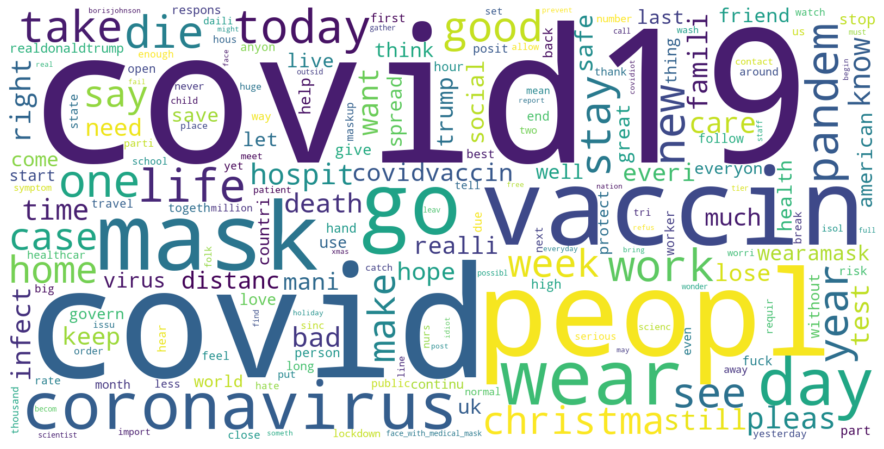

[('covid19', 299), ('covid', 196), ('peopl', 107), ('vaccin', 105), ('get', 91), ('mask', 78), ('go', 69), ('wear', 56), ('coronavirus', 44), ('day', 42), ('today', 40), ('one', 39), ('life', 38), ('die', 37), ('pandem', 37), ('work', 36), ('take', 35), ('stay', 33), ('good', 32), ('see', 32), ('week', 32), ('case', 31), ('make', 31), ('home', 31), ('year', 31), ('christma', 31), ('would', 29), ('say', 29), ('pleas', 29), ('know', 28), ('hospit', 27), ('19', 27), ('2', 27), ('want', 26), ('care', 26), ('time', 26), ('new', 25), ('cannot', 25), ('like', 25), ('still', 25), ('right', 25), ('famili', 24), ('1', 24), ('death', 23), ('bad', 23), ('test', 23), ('infect', 23), ('covidvaccin', 22), ('2020', 22), ('keep', 22), ('hope', 22), ('safe', 22), ('everi', 22), ('distanc', 21), ('realli', 21), ('need', 21), ('much', 21), ('social', 20), ('lose', 20), ('mani', 20), ('trump', 20), ('wearamask', 20), ('virus', 20), ('uk', 19), ('think', 19), ('american', 19), ('well', 19), ('spread', 19), 

In [46]:
build_wc(train_set, 'acknowledged')


In [47]:
howmany = Counter(word for tweet in train_set.texts() for word in tokenize(tweet))

In [48]:
howmany.most_common(50)

[('covid19', 907),
 ('covid', 502),
 ('vaccin', 308),
 ('case', 291),
 ('coronavirus', 235),
 ('peopl', 234),
 ('get', 217),
 ('new', 172),
 ('go', 163),
 ('death', 161),
 ('1', 131),
 ('day', 118),
 ('19', 115),
 ('2', 108),
 ('today', 107),
 ('test', 105),
 ('mask', 101),
 ('say', 99),
 ('take', 94),
 ('one', 90),
 ('pandem', 90),
 ('make', 87),
 ('total', 86),
 ('3', 85),
 ('work', 82),
 ('time', 79),
 ('2020', 75),
 ('see', 72),
 ('die', 69),
 ('would', 68),
 ('wear', 68),
 ('year', 68),
 ('like', 67),
 ('virus', 67),
 ('posit', 65),
 ('know', 64),
 ('need', 64),
 ('report', 64),
 ('hospit', 63),
 ('countri', 63),
 ('health', 62),
 ('week', 62),
 ('think', 61),
 ('still', 61),
 ('4', 61),
 ('use', 58),
 ('want', 57),
 ('home', 57),
 ('come', 57),
 ('good', 56)]

#### 2.2 Train & Evaluate

##### No Random oversampling / Synthetic Minority Oversampling Technique

In [73]:
#cnt = CountVectorizer(tokenizer=tokenize, max_df=0.15)
cnt = TfidfVectorizer(tokenizer=tokenize, max_df=0.15)
features_train = cnt.fit_transform(train_set.texts())
features_test = cnt.transform(test_set.texts())

In [74]:
#clf = MultinomialNB()
clf = ComplementNB()
#clf = GaussianNB
#clf = LogisticRegression()
#clf = LinearSVC()
clf.fit(features_train, train_set.labels_int())

ComplementNB()

In [75]:
predictions = clf.predict(features_test)

In [76]:
a = accuracy_score(test_set.labels_int(), predictions)
p, r, f, _ = precision_recall_fscore_support(test_set.labels_int(), predictions, average='macro')
print(f"Accuracy : {a:>.4f}")
print(f"Precision: {p:>.4f}")
print(f"Recall   : {r:>.4f}")
print(f"F-Score  : {f:>.4f}\n")

print(f"Prediction: \n"
      f"{Counter(label for label in predictions)}\n")

print(classification_report(test_set.labels_int(), predictions, target_names=[label for label, _ in LABELS]))

Accuracy : 0.5590
Precision: 0.5955
Recall   : 0.4596
F-Score  : 0.4577

Prediction: 
Counter({0: 165, 2: 125, 3: 21, 1: 11})

              precision    recall  f1-score   support

acknowledged       0.49      0.76      0.60       107
     opposed       0.73      0.16      0.27        49
     neutral       0.64      0.71      0.68       112
   unrelated       0.52      0.20      0.29        54

    accuracy                           0.56       322
   macro avg       0.60      0.46      0.46       322
weighted avg       0.58      0.56      0.52       322



In [116]:
results_1 = optimize(train_set, test_set)

progress:   0%|          | 0/29 [00:00<?, ?it/s]

In [117]:
results_1.head(30)

,max_df,Accuracy,Precision,Recall,F-Score
0,1.00,0.543478,0.584821,0.451067,0.453529
1,0.01,0.487578,0.479191,0.452707,0.461052
2,0.02,0.527950,0.513045,0.465408,0.473252
3,0.03,0.552795,0.544055,0.481807,0.488772
4,0.04,0.540373,0.546296,0.467506,0.475919
5,0.05,0.562112,0.578778,0.483340,0.492734
6,0.06,0.559006,0.581138,0.481212,0.490268
7,0.07,0.546584,0.576155,0.469309,0.478341
8,0.08,0.546584,0.580217,0.472075,0.482349
9,0.09,0.543478,0.574649,0.466973,0.476510


In [113]:
results_2.head(30)

,max_df,Accuracy,Precision,Recall,F-Score
0,1.0,0.555901,0.546942,0.503642,0.514188
1,0.1,0.580745,0.562103,0.520659,0.530877
2,0.2,0.559006,0.549104,0.503004,0.513897
3,0.3,0.559006,0.548160,0.505874,0.516276
4,0.4,0.559006,0.548160,0.505874,0.516276
5,0.5,0.559006,0.548160,0.505874,0.516276
6,0.6,0.559006,0.548160,0.505874,0.516276
7,0.7,0.559006,0.548160,0.505874,0.516276
8,0.8,0.555901,0.546942,0.503642,0.514188
9,0.9,0.555901,0.546942,0.503642,0.514188


##### With Random oversampling / Synthetic Minority Oversampling Technique

In [62]:
ros = SMOTE(random_state=11)
#ros = RandomOverSampler(random_state=5)

In [63]:
train_data_ros, y_train_ros = ros.fit_resample(features_train, train_set.labels_int())

In [64]:
#clf = ComplementNB()
#clf = MultinomialNB()
clf.fit(train_data_ros, y_train_ros)

ComplementNB()

In [65]:
predictions = clf.predict(features_test)

In [66]:
a = accuracy_score(test_set.labels_int(), predictions)
p, r, f, _ = precision_recall_fscore_support(test_set.labels_int(), predictions, average='macro')
print(f"Accuracy : {a:>.4f}")
print(f"Precision: {p:>.4f}")
print(f"Recall   : {r:>.4f}")
print(f"F-Score  : {f:>.4f}\n")

print(f"Prediction: \n"
      f"{Counter(label for label in predictions)}\n")

print(classification_report(test_set.labels_int(), predictions, target_names=[label for label, _ in LABELS]))

Accuracy : 0.5248
Precision: 0.4938
Recall   : 0.4837
F-Score  : 0.4842

Prediction: 
Counter({0: 119, 2: 90, 1: 66, 3: 47})

              precision    recall  f1-score   support

acknowledged       0.55      0.62      0.58       107
     opposed       0.27      0.37      0.31        49
     neutral       0.72      0.58      0.64       112
   unrelated       0.43      0.37      0.40        54

    accuracy                           0.52       322
   macro avg       0.49      0.48      0.48       322
weighted avg       0.55      0.52      0.53       322



In [696]:
features_train = features_train.toarray()
features_test = features_test.toarray()

In [697]:
#label_lookup = 'opposed'

howclean = [tweet for tweet, _ , _ in full_corpus] # if label == label_lookup]
len(howclean)

1598

In [698]:
howclean2 = []
for token in howclean:
    howclean2.append(tokenize(token))

In [699]:
for i in range(0,len(howclean)):
    print(f"Input : {howclean[i]}")
    print(f"Tokens : {howclean2[i]} \n")

Input : Hey @realDonaldTrump  I need a #Pardon too, a #rentpardpn for the last six months of rent because of how you fucked up the #COVID19 pandemic response!
Tokens : ['hey', 'real', 'donald', 'trump', 'need', 'pardon', 'rentpardpn', 'last', 'six', 'month', 'rent', 'fuck', 'covid19', 'pandem', 'respons'] 

Input : Wow they got transformers 7 coming out in the summer we better hope this #COVID19 will be going away
Tokens : ['wow', 'get', 'transform', '7', 'come', 'summer', 'good', 'hope', 'covid19', 'go', 'away'] 

Input : Just because politicians are human (and therefore hypocrites) does not necessarily mean their recommendations should not be followed #justsayin' #COVID19
Tokens : ['politician', 'human', 'therefor', 'hypocrit', 'necessarili', 'mean', 'recommend', 'follow', 'justsayin', 'covid19'] 

Input : so the #corona has done century
Tokens : ['corona', 'centuri'] 

Input : Hey teachers: Thank you for all of your efforts in 2020! All students and teachers are working daily to sur

In [700]:
'''
wc_text = ''
for word in [sentence for sentence in howclean2]:
    inter = " ".join(token for token in word)
    wc_text += ' ' + inter
wordcloud = WordCloud(width=1600, height=800, background_color="white", collocations=False).generate(wc_text)
plt.figure(figsize=[16,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
'''

'\nwc_text = \'\'\nfor word in [sentence for sentence in howclean2]:\n    inter = " ".join(token for token in word)\n    wc_text += \' \' + inter\nwordcloud = WordCloud(width=1600, height=800, background_color="white", collocations=False).generate(wc_text)\nplt.figure(figsize=[16,8])\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.show()\n'

In [701]:
count = Counter(token for token in [word for tweet in howclean2 for word in tweet])

In [702]:
len(count)

6610

In [703]:
[print(f"Word: {word}\nCount: {count}") for word, count in count.most_common(50)]



Word: covid19
Count: 1316
Word: casenum
Count: 887
Word: covid
Count: 599
Word: vaccin
Count: 486
Word: case
Count: 346
Word: coronavirus
Count: 324
Word: peopl
Count: 295
Word: get
Count: 285
Word: new
Count: 247
Word: go
Count: 214
Word: death
Count: 205
Word: mask
Count: 184
Word: perc
Count: 169
Word: day
Count: 159
Word: pandem
Count: 147
Word: trump
Count: 141
Word: say
Count: 140
Word: virus
Count: 136
Word: today
Count: 136
Word: corona
Count: 133
Word: one
Count: 132
Word: thisyear
Count: 128
Word: wear
Count: 125
Word: test
Count: 124
Word: take
Count: 121
Word: work
Count: 110
Word: make
Count: 110
Word: year
Count: 108
Word: time
Count: 106
Word: stay
Count: 104
Word: home
Count: 102
Word: like
Count: 101
Word: total
Count: 101
Word: health
Count: 100
Word: christma
Count: 94
Word: 1
Count: 93
Word: see
Count: 91
Word: would
Count: 91
Word: die
Count: 89
Word: 2
Count: 89
Word: know
Count: 86
Word: need
Count: 84
Word: think
Count: 84
Word: still
Count: 80
Word: report
Coun

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]